ChEn-3170: Computational Methods in Chemical Engineering Fall 2018 UMass Lowell; Prof. V. F. de Almeida **03Dec2018**

# 15. Multiple Reactions at Equilibrium
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{x}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\gradx}{\nabla\!_{\xvec}}
  \newcommand{\Kcal}{\mathcal{K}}
  \newcommand{\epsvec}{\boldsymbol{\varepsilon}}
$

---
## Table of Contents
* [Introduction](#intro)
* [Algorithm](#algo)
---

## Introduction<a id="intro"></a>
Newton's method for computing roots of multiple non-linear equations, $\Kcal\bigl(\xvec(\widehat{\epsvec})\bigr)=0$, is described [here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EmWlQK3zr2xDu2YWkfFCoZYB2dunRc4yHyxu4X5d-owMnA?e=jF7cfF).


## Algorithm<a id="algo"></a>

Given $\Kcal\bigl(\xvec(\widehat{\epsvec})\bigr)$, find the root

\begin{equation*}
\Kcal\bigl(\xvec(\widehat{\epsvec})\bigr) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\epsvec}_0$.


## Data<a id="data"></a>
Newton's method for computing roots of multiple non-linear equations, $\Kcal\bigl(\xvec(\widehat{\epsvec})\bigr)=0$, is described [here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EmWlQK3zr2xDu2YWkfFCoZYB2dunRc4yHyxu4X5d-owMnA?e=jF7cfF).


In [1]:
'''Import the ammonia reaction mechanism'''

try:    
    from chen_3170.toolkit import reaction_mechanism   
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'
    
# read species, reactions, equilibrium constants and build the stoichiometric matrix
(species, reactions, keq_cte, stoic_mtrx) = reaction_mechanism('data/ammonia-rxn.txt')

In [2]:
'''Sanity check on the data'''

print('species=',species)
from chen_3170.help import print_reactions
print('')
print_reactions(reactions) 
print('')
print('K_x eq = ',keq_cte)
print('')
from chen_3170.help import plot_matrix
plot_matrix(stoic_mtrx, title='Stoichiometric Matrix')
print('')
import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)

species= ['H2O', 'O2', 'NO', 'NH3', 'NO2', 'N2']

r0 :  4 NH3 + 5 O2 <=> 4 NO + 6 H2O
r1 :  4 NH3 + 3 O2 <=> 2 N2 + 6 H2O
r2 :  4 NH3 + 6 NO <=> 5 N2 + 6 H2O
r3 :  2 NO + 1 O2 <=> 2 NO2
r4 :  2 NO <=> 1 N2 + 1 O2
r5 :  1 N2 + 2 O2 <=> 2 NO2
r6 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2 + 6 H2O
n_reactions = 7

K_x eq =  [250.0, 180.0, 109.9692, 100.0, 0.8485281, 117.8511, 129.6]

matrix shape = (7, 6)


<Figure size 2000x400 with 1 Axes>


stoic_mtrx=
 [[ 6. -5.  4. -4.  0.  0.]
 [ 6. -3.  0. -4.  0.  2.]
 [ 6.  0. -6. -4.  0.  5.]
 [ 0. -1. -2.  0.  2.  0.]
 [ 0.  1. -2.  0.  0.  1.]
 [ 0. -2.  0.  0.  2. -1.]
 [ 6. -1. -4. -4.  0.  4.]]


In [3]:
'''Check the rank of the stoichiometric matrix'''

try:    
    from chen_3170.toolkit import matrix_rank    
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

rank = matrix_rank( stoic_mtrx )
print('stoic_mtrx m x n =',stoic_mtrx.shape)
print('stoic_mtrx rank =',rank)

stoic_mtrx m x n = (7, 6)
stoic_mtrx rank = 3


In [4]:
'''Build the full-rank sub-mechanism reactions list'''

try:    
    from chen_3170.toolkit import sub_mechanisms    
except ModuleNotFoundError:
    assert False, 'You need to provide your own sub_mechanisms function here. Bailing out.'

sub_mechanisms = sub_mechanisms( species, reactions, keq_cte, stoic_mtrx )

# reactions =  7
# species   =  6
rank of S =  3
# of all possible sub_mechanisms = 35
# of full-rank sub_mechanisms = 24


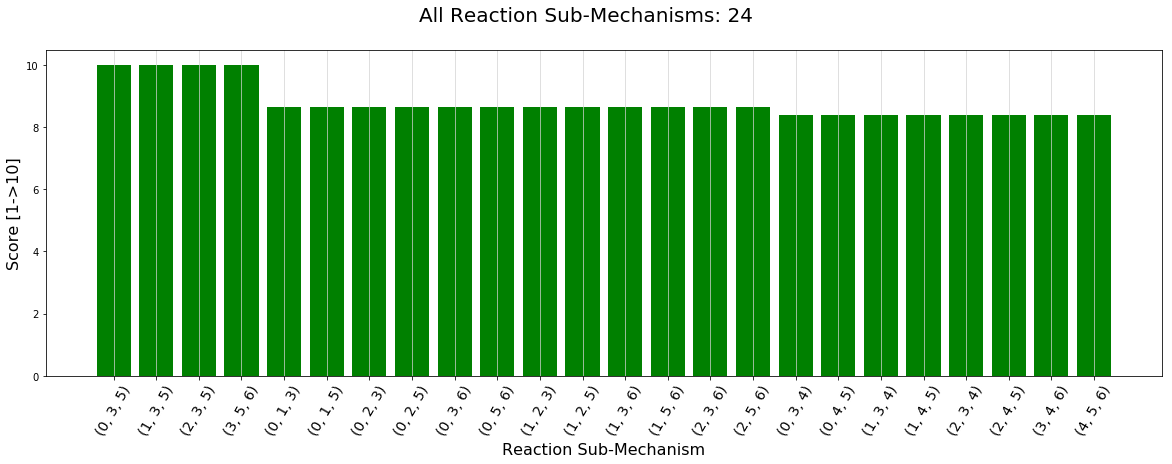

In [5]:
try:    
    from chen_3170.toolkit import plot_reaction_mechanisms    
except ModuleNotFoundError:
    assert False, 'You need to provide your own plot_reaction_mechanisms function here. Bailing out.'
    
plot_reaction_mechanisms( sub_mechanisms )

In [ ]:
'''Select the first sub-mechanims'''

sub_mechanism_1 = sub_mechanisms[0]

for i in sub_mechanism_1:
    print(i)
    
stoic_mtrx = sub_mechanism_1[3]
keq_cte    = np.array(sub_mechanism_1[2])

In [6]:
'''Molar fractions function'''

def molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ):
    
    assert abs(x_vec_0.sum()-1.0) <= 1e-10
    assert abs( 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum() ) >= 1e-8
    
    x_vec = ( x_vec_0 + stoic_mtrx.transpose()@ext_hat_vec ) / \
            ( 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum() )
    
    return x_vec

In [25]:
import numpy as np
a = np.random.random(6)
print(a)
b = np.random.random(7)
print(b.transpose())
np.outer(a,b).shape
S = np.random.random((3,6))
print((S.transpose()).sum(1))

[0.694 0.613 0.842 0.226 0.441 0.325]
[0.169 0.593 0.127 0.28  0.383 0.658 0.146]
[1.339 1.357 1.568 1.405 1.921 1.278]


In [26]:
'''Derivative of the molar fractions function wrt normalized extent of reaction'''

def d_ext_molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ):
    
    denom  = 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum()
    denom2 = denom**2
    
    dext_x_vec =  stoic_mtrx.transpose() / denom \
                -  np.outer( x_vec_0 + stoic_mtrx.transpose()@ext_hat_vec, (stoic_mtrx.trasnpose()).sum(1) ) / \
                   denom2
    
    return dext_x_vec

In [ ]:
'''Equilibrium function'''

def keq_function( x_vec, eq_kx_cte, stoic_row ):
    
    value = eq_kx_cte - x_vec[0]**stoic_row[0] * x_vec[1]**stoic_row[1] \
                        * x_vec[2]**stoic_row[2] * x_vec[3]**stoic_row[3]
    
    return value